<a href="https://colab.research.google.com/github/hy2632/SystematicTrading/blob/main/TestStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtrader
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

     |████████████████████████████████| 419kB 5.5MB/s 
Selecting previously unselected package libta-lib0.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 4.3MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437803 sha256=e1b563ac026ed5fc6c9cd59fe705aa88c035ecc07066c264e78421e0b105e2c3
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f11

In [2]:
import backtrader as bt
import datetime
import talib

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Basic: Print Close & 7days MA

In [12]:
class PrintClose(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.ma7 = bt.talib.SMA(self.datas[0].close, timeperiod=7)

    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s, %s" % (dt.isoformat(), txt))
              
    def next(self):
        self.log("Close: %.2f" % self.dataclose[0])
        self.log("7 Days MA: %.2f" % self.ma7[0])
 

In [34]:
cerebro = bt.Cerebro()
data = bt.feeds.YahooFinanceData(
    dataname="AAPL", 
    fromdate = datetime.datetime(2020,11,1), 
    todate = datetime.datetime(2020,12,31)
)
cerebro.adddata(data)
cerebro.addstrategy(PrintClose)
cerebro.run()

2020-11-10, Close: 115.97
2020-11-10, 7 Days MA: 114.77
2020-11-11, Close: 119.49
2020-11-11, 7 Days MA: 116.33
2020-11-12, Close: 119.21
2020-11-12, 7 Days MA: 117.61
2020-11-13, Close: 119.26
2020-11-13, 7 Days MA: 118.25
2020-11-16, Close: 120.30
2020-11-16, 7 Days MA: 118.46
2020-11-17, Close: 119.39
2020-11-17, 7 Days MA: 118.56
2020-11-18, Close: 118.03
2020-11-18, 7 Days MA: 118.81
2020-11-19, Close: 118.64
2020-11-19, 7 Days MA: 119.19
2020-11-20, Close: 117.34
2020-11-20, 7 Days MA: 118.88
2020-11-23, Close: 113.85
2020-11-23, 7 Days MA: 118.12
2020-11-24, Close: 115.17
2020-11-24, 7 Days MA: 117.53
2020-11-25, Close: 116.03
2020-11-25, 7 Days MA: 116.92
2020-11-27, Close: 116.59
2020-11-27, 7 Days MA: 116.52
2020-11-30, Close: 119.05
2020-11-30, 7 Days MA: 116.67
2020-12-01, Close: 122.72
2020-12-01, 7 Days MA: 117.25
2020-12-02, Close: 123.08
2020-12-02, 7 Days MA: 118.07
2020-12-03, Close: 122.94
2020-12-03, 7 Days MA: 119.37
2020-12-04, Close: 122.25
2020-12-04, 7 Days MA:

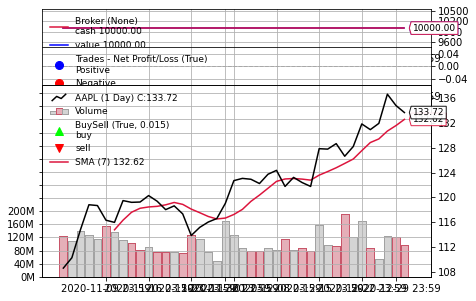

In [35]:
cerebro.plot()[0][0]

# Adding an indicator: MA15

Trend Follower: get good return from bullish stock.

In [50]:
class TestStrategy(bt.Strategy):
    params = dict(maperiod = 15)
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")
        
    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod
        )

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    "BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f" %
                    (
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm
                    )
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else: 
                self.log(
                    "SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm: %.2f" %
                    (
                        order.executed.price,
                        order.executed.value,
                        order.executed.comm
                    )
                )
            self.bar_executed = len(self)
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        self.log("CLose, %.2f" % self.dataclose[0])

        if self.order:
            return
        
        if not self.position:
            if self.dataclose[0] > self.sma[0]:
                self.log("BUY CREATE, %.2f" % self.dataclose[0])
                self.order = self.buy()
        
        else:
            if self.dataclose[0] < self.sma[0]:
                self.log("SELL CREATE, %.2f" % self.dataclose[0])
                self.order = self.sell()

# if __name__ == "__main__":
#     cerebro = bt.Cerebro()
#     cerebro.addstrategy(TestStrategy)

#     data = bt.feeds.YahooFinanceData(
#         dataname = "AAPL",
#         fromdate = datetime.datetime(2020, 12, 1),
#         todate = datetime.datetime(2020, 12, 31)
#     )

#     cerebro.adddata(data)
#     cerebro.broker.setcash(1000.0)
#     cerebro.addsizer(bt.sizers.FixedSize, stake=10)
#     cerebro.broker.setcommission(commission=0.0)

#     print("Starting Portfoli Value: %.2f" % cerebro.broker.getvalue())

#     cerebro.run()

#     print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

Starting Portfoli Value: 1000.00
2019-01-23, CLose, 19.80
2019-01-24, CLose, 20.85
2019-01-24, BUY CREATE, 20.85
2019-01-25, BUY EXECUTED, Price: 20.99, Cost: 209.90, Comm: 0.00
2019-01-25, CLose, 21.93
2019-01-28, CLose, 20.18
2019-01-28, SELL CREATE, 20.18
2019-01-29, SELL EXECUTED, Price: 20.26, Cost: 209.90, Comm: 0.00
2019-01-29, OPERATION PROFIT, GROSS -7.30, NET -7.30
2019-01-29, CLose, 19.25
2019-01-30, CLose, 23.09
2019-01-30, BUY CREATE, 23.09
2019-01-31, BUY EXECUTED, Price: 23.02, Cost: 230.20, Comm: 0.00
2019-01-31, CLose, 24.41
2019-02-01, CLose, 24.51
2019-02-04, CLose, 24.13
2019-02-05, CLose, 23.31
2019-02-06, CLose, 23.26
2019-02-07, CLose, 22.67
2019-02-08, CLose, 23.05
2019-02-11, CLose, 22.96
2019-02-12, CLose, 22.82
2019-02-13, CLose, 22.85
2019-02-14, CLose, 23.13
2019-02-15, CLose, 23.68
2019-02-19, CLose, 23.95
2019-02-20, CLose, 23.95
2019-02-21, CLose, 23.92
2019-02-22, CLose, 24.36
2019-02-25, CLose, 24.71
2019-02-26, CLose, 24.21
2019-02-27, CLose, 23.48
20

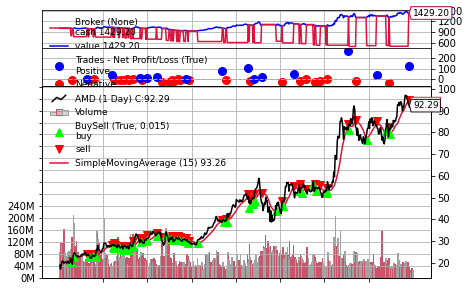

In [59]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname = "AMD",
    fromdate = datetime.datetime(2019, 1, 1),
    todate = datetime.datetime(2020, 12, 31)
)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.0)

print("Starting Portfoli Value: %.2f" % cerebro.broker.getvalue())

cerebro.run()

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
cerebro.plot()[0][0]    